# 模型评估(Model Evaluation)
> 没有测量，就没有科学。 -- 门捷列夫
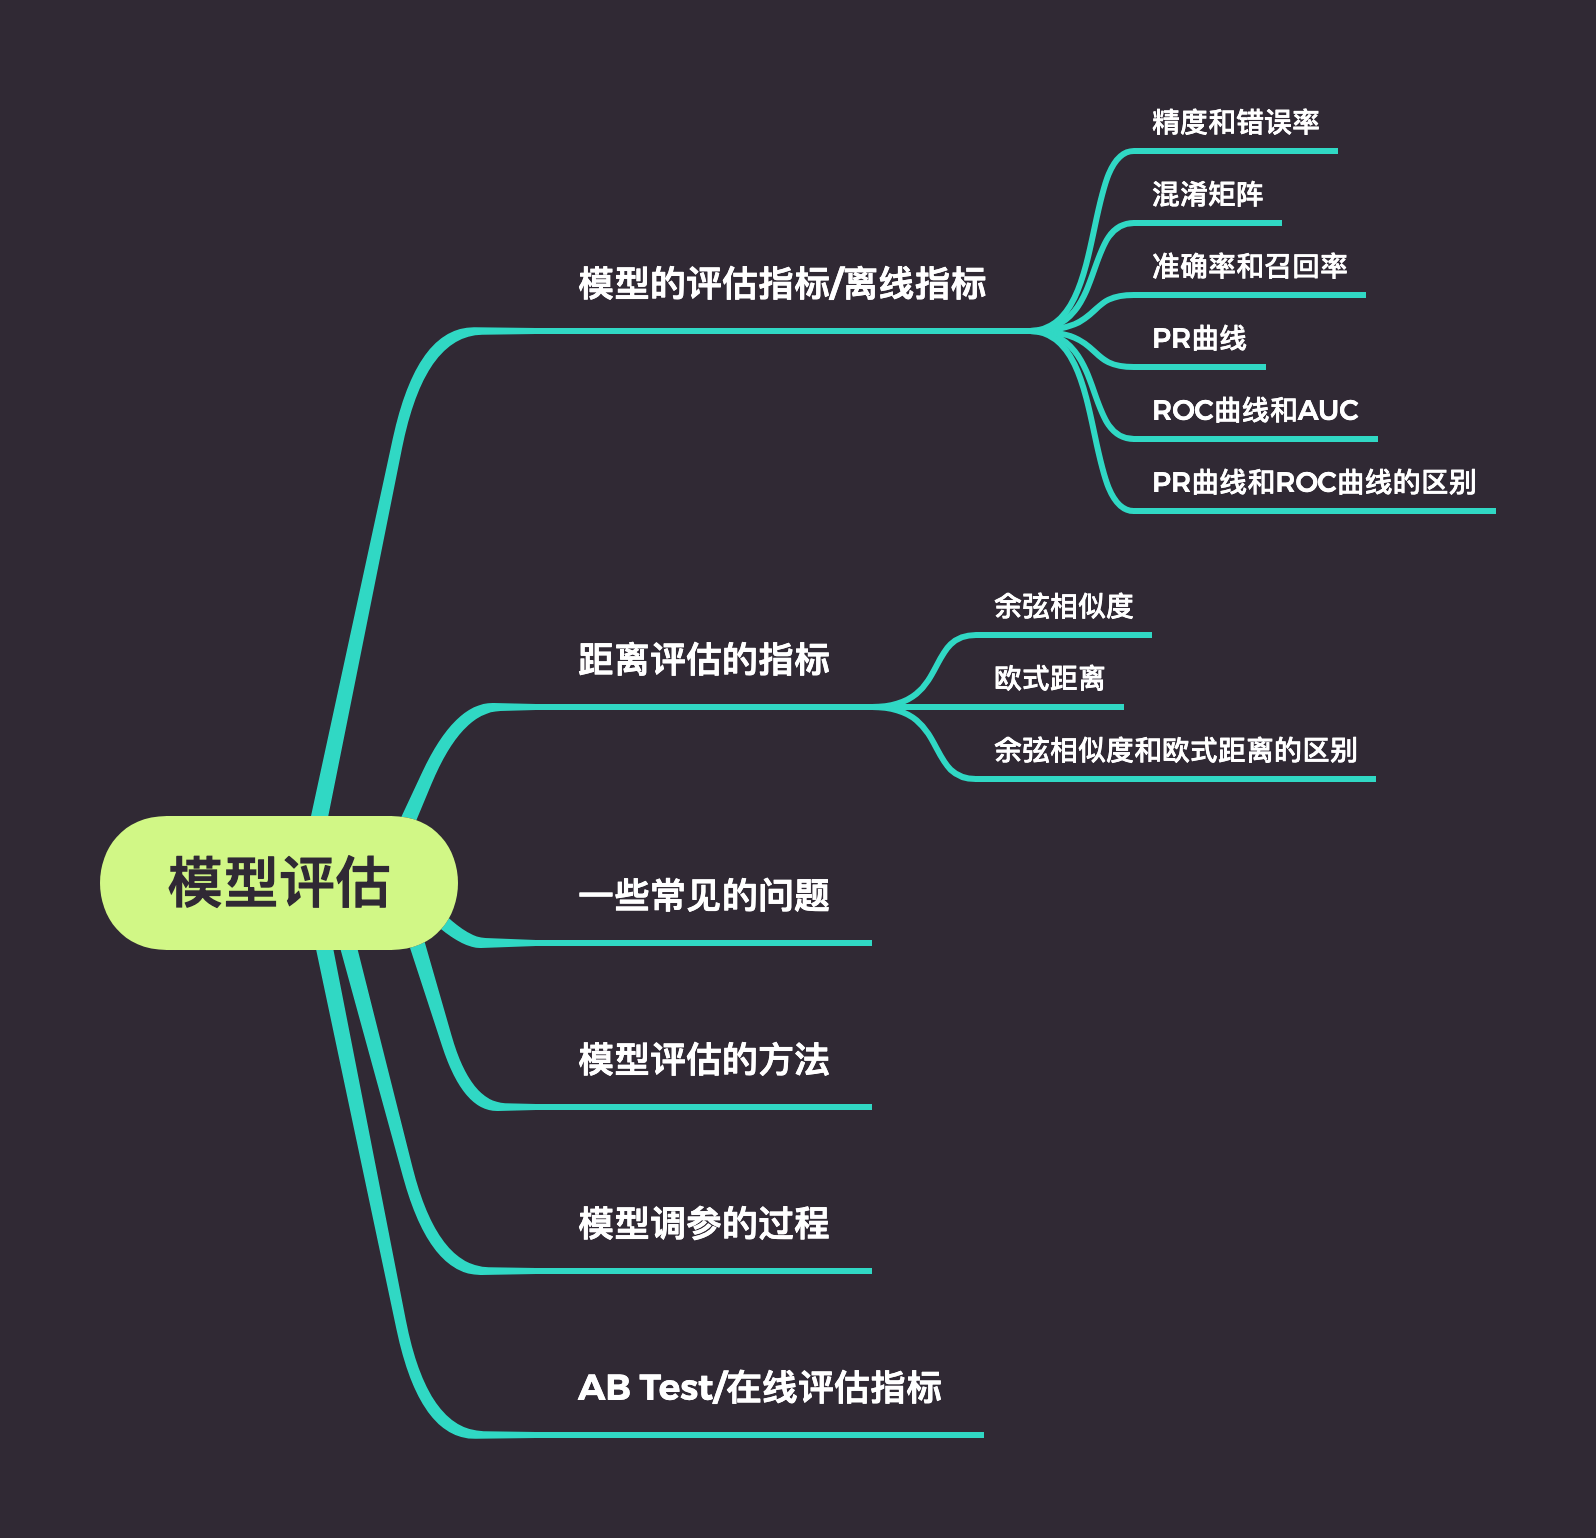

## 模型的评估指标/离线指标
大部分指标只能片面的反应模型的一部分性能，所以在不同的问题上，需要选择合适的评估指标。

### 精度(Accuracy Rate)和错误率(Error Rate)

Accuracy Rate 是平时说的最多的一个指标，就是被预测正确的样本的比例有多少。

$Error =1-Acc$

Accuracy的问题：
- 这样简单的评估指标在真实的场景中会存在问题，比如在一个对医疗图像判断阳性和阴性的二分类系统中，在100个训练样本中存在99个阴性样本，1个阳性样本，只要我们给所有的样本都预测成阴性，就能得到99%的Acc。这样显然是有问题的，我们需要一种更好的评价指标，来评价真实的业务中经常出现的数据不均衡的情况。
- 可以使用平均准确率，即每个类别下的样本准确率的算术平均。

### 混淆矩阵(Confusion Matrix)
再介绍一个非常容易被弄“混淆”的表格，混淆矩阵(Confusion Matrix)。

In [61]:
# 随机生成一组样本的标签，值都是0和1
# 生成一组预测值
import numpy as np
import pandas as pd

sample_size = 10
df = pd.DataFrame({'label':  np.random.randint(0, 2, sample_size), 'predict': np.random.randint(0, 2, sample_size)})
print(df)

   label  predict
0      0        0
1      1        0
2      1        0
3      0        0
4      0        0
5      1        1
6      0        1
7      0        1
8      1        0
9      0        0


In [62]:
# 计算样本有多少个是1的标签(阳性样本)，多少个是0的标签(阴性样本)
positive = len(df[df['label'] == 1])
negative = len(df[df['label'] == 0])
print('positive(阳性样本): ', positive)
print('negative(阴性样本): ', negative)

positive(阳性样本):  4
negative(阴性样本):  6


In [74]:
def calculate_matrics(df, predict_key='predict', label_key='label'):
    # 计算预测为阳性的样本中有多少个是正确的true positive(真阳性个数), 计算预测为阳性的样本中有多少个是错误的false positive(假阳性个数)
    df['is_correct'] = df.apply(lambda x: x[predict_key] == x[label_key], axis=1)
    true_positive = df[(df[predict_key] == 1) & (df['is_correct'] == True)].shape[0]
    false_positive = df[(df[predict_key] == 1) & (df['is_correct'] == False)].shape[0]
    
    # 计算预测中有多少个阴性样本被预测正确true negtive(真阴性个数), 计算有多少个阴性样本被预测错误false negtive(假阴性个数)
    false_negtive = df[(df[predict_key] == 0) & (df['is_correct'] == False)].shape[0]
    true_negtive = df[(df[predict_key] == 0) & (df['is_correct'] == True)].shape[0]
    return true_positive, false_positive, false_negtive, true_negtive

true_positive, false_positive, false_negtive, true_negtive = calculate_matrics(df)
print('true positive(真阳性个数):', true_positive)
print('false positive(假阳性个数):', false_positive)
print('false positive(假阳性个数)', false_negtive)
print('true negtive(真阳性个数)', true_negtive)

true positive(真阳性个数): 1
false positive(假阳性个数): 2
false positive(假阳性个数) 3
true negtive(真阳性个数) 4


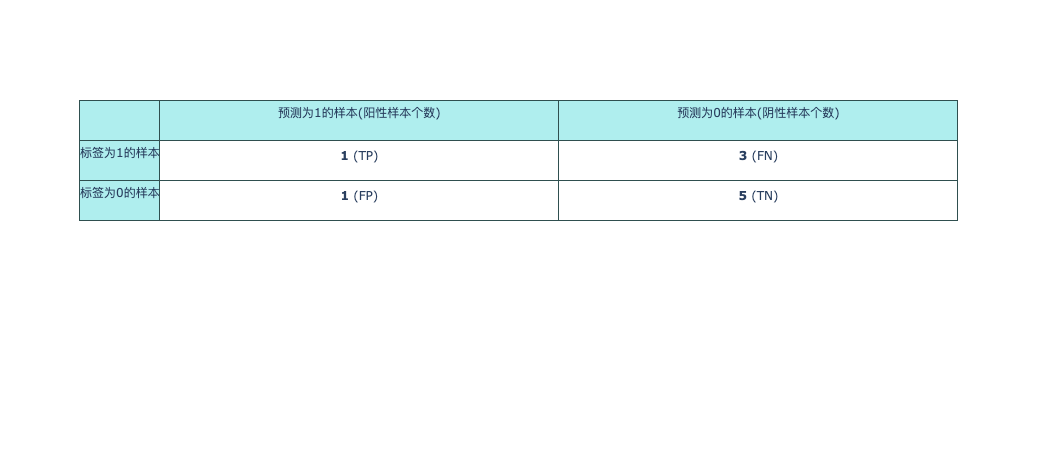

In [50]:
# 将上述计算的数值填写到混淆矩阵中
import plotly.graph_objects as go

data_matrix = [['标签为1的样本', '标签为0的样本'],
               ['<b>{}</b> (TP)'.format(true_positive), '<b>{}</b> (FP)'.format(false_positive)],
               ['<b>{}</b> (FN)'.format(false_negtive), '<b>{}</b> (TN)'.format(true_negtive)]
              ]
header = dict(line_color='darkslategray', height=40, fill_color='paleturquoise', values=[[], ['预测为1的样本(阳性样本个数)'], ['预测为0的样本(阴性样本个数)']])
cells = dict(line_color='darkslategray', height=40, values=data_matrix, fill=dict(color=['paleturquoise', 'white']))
table = go.Table(columnwidth=[80, 400], header=header, cells=cells)
fig = go.Figure(data=[table])
fig.show()

### 准确率(Precision)、召回率(Recall)和F1 Score

准确率(P) = TP / TP + FP; 用来描述预测为阳性的样本中，有多少个是预测正确的。

召回率(R) = TP / TP + FN；用来描述阳性的样本中，有多少个被预测为正确的。

由于在实际的问题中，比较两个值是一件很麻烦的事情，所以我们将以上两个值采用一些调和的方法，统一成一个指标。

$F1 = 2*PR / P + R$

In [78]:
def calculate_p_r(tp, fp, fn):
    P = tp / (tp + fn + 1)
    R = tp / (tp + fp + 1)
    return P, R

P, R = calculate_p_r(true_positive, false_positive, false_negtive)
F1 = (2 * P * R) / (P + R + 1)
print('P:', P)
print('R:', R)
print('F1:', F1)

P: 0.2
R: 0.25
F1: 0.06896551724137931


在以上的介绍中，我们有一个预测值是被直接定义的预测正确(1)和预测错误(0)，但是在我们真实的环境中，预测出来的值往往是一个百分比，有多少百分比的概率是某一种分类。在判断是否为该分类时，
我们往往还需要一个阈值，大于这个阈值的我们就认为是改分类。我们把这个阈值叫做**截断点**。P-R曲线、ROC和AUC既是我们在这样一种真实的情景下，提出的衡量模型的指标。

### P-R曲线
P-R曲线的绘制方法是以召回率为x轴，准确率为y轴，截断点从高到低移动的轨迹曲线。

In [82]:
# 随机生成一些数据
import numpy as np
import pandas as pd

sample_size = 10
df = pd.DataFrame({'label':  np.random.randint(0, 2, sample_size), 
                   'predict1': np.random.random_sample(sample_size), 
                   'predict2': np.random.random_sample(sample_size)})
print(df)    

   label  predict1  predict2
0      1  0.299360  0.681244
1      1  0.265810  0.956577
2      1  0.439630  0.690291
3      0  0.198899  0.526776
4      0  0.945547  0.902533
5      0  0.521992  0.112601
6      1  0.571816  0.686490
7      1  0.338966  0.445357
8      1  0.674876  0.274624
9      1  0.621259  0.815405


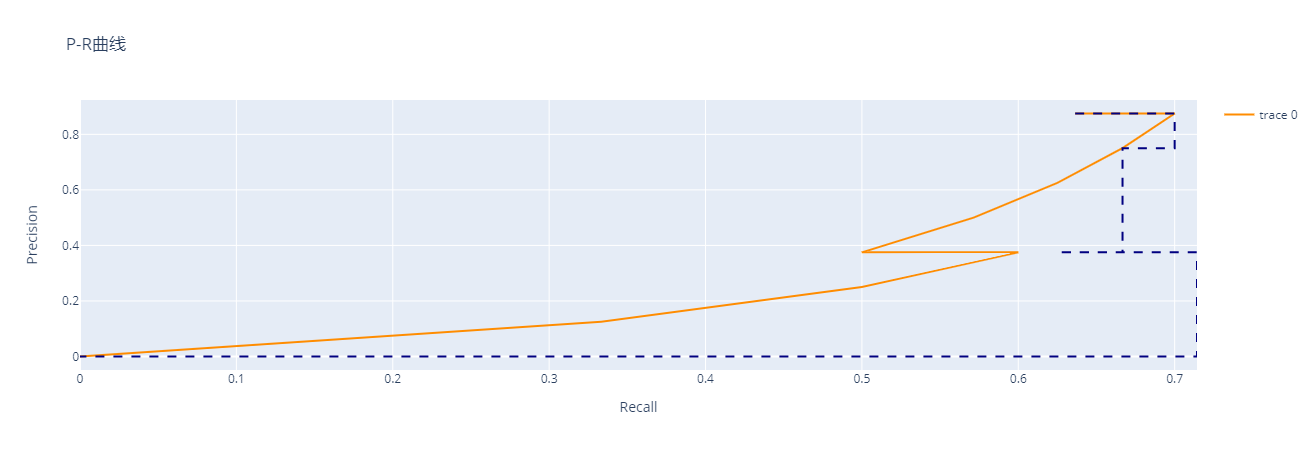

In [84]:
Ps1, Ps2 = [], []
Rs1, Rs2 = [], []
threadholds = sorted(np.random.random_sample(100))
for threadhold in threadholds:
    copy_df = df.copy()
    copy_df['predict1'] = copy_df.apply(lambda x: 1 if x['predict1'] >= threadhold else 0, axis=1)
    copy_df['predict2'] = copy_df.apply(lambda x: 1 if x['predict2'] >= threadhold else 0, axis=1)
    tp1, fp1, fn1, tn1 = calculate_matrics(copy_df, predict_key='predict1')
    tp2, fp2, fn2, tn2 = calculate_matrics(copy_df, predict_key='predict2')
    P1, R1 = calculate_p_r(tp1, fp1, fn1)
    P2, R2 = calculate_p_r(tp2, fp2, fn2)
    Ps1.append(P1)
    Rs1.append(R1)
    Ps2.append(P2)
    Rs2.append(R2)

# 绘制P-R曲线
import plotly.graph_objs as go

trace1 = go.Scatter(x=Rs1, y=Ps1, mode='lines', line=dict(color='darkorange', width=2))
trace2 = go.Scatter(x=Rs2, y=Ps1, mode='lines', line=dict(color='navy', width=2, dash='dash'), showlegend=False)
layout = go.Layout(title='P-R曲线', xaxis=dict(title='Recall'), yaxis=dict(title='Precision'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

### ROC曲线和AUC

在介绍这两个指标之前，还需要先介绍两个概念。

**TPR**既是上文中讲到的准确率P，又叫做真阳性率。**真实的阳性样本中，被预测正确的比例。**

**FPR**为FP/FP+TN，叫做假阴性率。**真实的阴性样本中，被预测错误的比例。**

ROC曲线既是以TPR作为纵坐标，FPR作为横坐标绘制出的曲线图。

AUC为ROC横轴积分积分面积。

In [85]:
import numpy as np
import pandas as pd

sample_size = 10
df = pd.DataFrame({'label':  np.random.randint(0, 2, sample_size), 'predict': np.random.random_sample(sample_size)})
print(df)

   label   predict
0      0  0.284741
1      0  0.025560
2      0  0.525770
3      1  0.347590
4      0  0.499731
5      0  0.655356
6      1  0.628301
7      1  0.885564
8      0  0.161443
9      0  0.193796


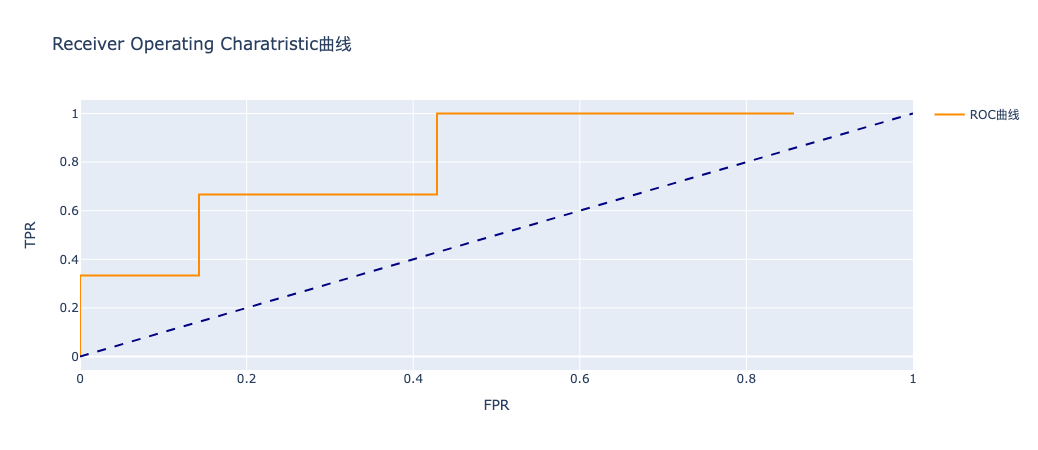

In [86]:
def calculate_tpr_fpr(tp, fp, fn, tn):
    return tp/(tp+fn), fp/(fp+tn)

# 计算在不同阈值情况下的tpr和fpr
tprs = []
fprs = []
threadholds = sorted(np.random.random_sample(100))
for threadhold in threadholds:
    copy_df = df.copy()
    copy_df['predict'] = copy_df.apply(lambda x: 1 if x['predict'] >= threadhold else 0, axis=1)
    true_positive, false_positive, false_negtive, true_negtive = calculate_matrics(copy_df)
    tpr, fpr = calculate_tpr_fpr(true_positive, false_positive, false_negtive, true_negtive)
    tprs.append(tpr)
    fprs.append(fpr)

# 绘制ROC曲线
import plotly.graph_objs as go

trace1 = go.Scatter(x=fprs, y=tprs, mode='lines', line=dict(color='darkorange', width=2), name='ROC曲线')
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'), showlegend=False)
layout = go.Layout(title='Receiver Operating Charatristic曲线', xaxis=dict(title='FPR'), yaxis=dict(title='TPR'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

### PR曲线和ROC曲线的区别
- 在数据集发生变化时，ROC曲线的变化很小，而PR曲线的变化非常大。这个特点让ROC曲线能够尽量降低不同测试集的干扰，更加客观的衡量模型本身。
- 如果想更多的看到模型在指定数据集上的表现，则PR曲线能够更直观的反映性能。

## 距离的评估指标

### 余弦相似度
$\cos (\theta ) =   \dfrac {A \cdot B} {\left\| A\right\| _{2}\left\| B\right\| _{2}} $

取值范围[-1, 1]，当距离为1时则说明两者相同。

### 欧式距离
$d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } $

### 余弦相似度和欧式距离的区别
- 余弦相似度表示两向量夹角越小，则越相近，这在高纬度的空间中也是适用的；但是欧式距离在高维度空间中通常会很大。
- 在一些向量模长归一化的场景中，比如说Word2Vec中，他们之间有着单调的关系，可以通过公式进行换算。
- 总体上来说，余弦相似度表示方向上的想对差异；而欧式距离体现数值上的绝对差异，我们存在量上的对比时使用欧式距离更合适。比如说以登录次数和平均观看时长作为特征时，余弦距离会认为(1,10)和(10,100)所代表的两个用户很相似，但是显然这两个用户的活跃度的差异很大，所以使用欧式距离更合适。

## 一些常见的问题

### 模型准确率正常的情况下，回归模型中使用RMSE很大
$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$

比如说预测房价，模型准确率在95%，但是RMSE却很高。这是因为那些落在5%的数据中出现了离群数据，使得RMSE的值变高。
- 可以在于处理阶段，将这些离群点当成是异常值过滤掉
- 进一步提高模型的能力，将利群店背后所代表的的信息建模进去
- 可以使用MAPE(平均绝对百分比误差)进行评估

## 模型评估方法

### 留出法(hold-out)
将原始样本集合随机划分成训练集和验证集两部分，划分时采用stratified sampling保持正负样本的一致性。

缺点：
- 验证集上计算出俩的最后评估指标和原始分组有很大关系，为了消除随机性，引入"交叉验证".

### k折交叉验证法(k-fold cross validataion)
使用多次学习来使得模型达到稳定性，也可帮助调参/选择模型/特征等。k经常选择5或者10.
- 可以利用GridSearch、k-cross-validation快速的自动进行参数的调整

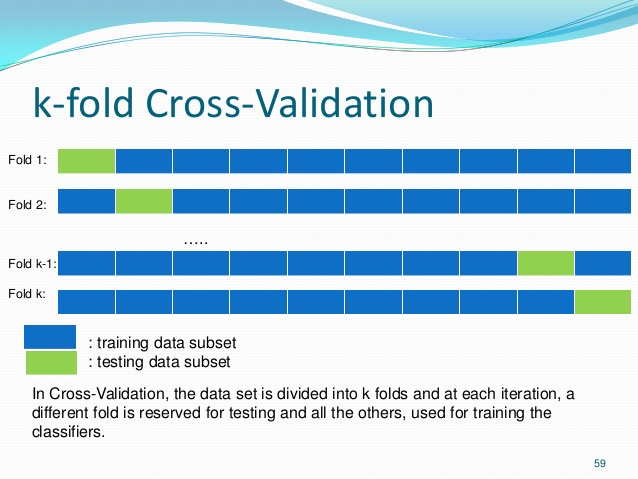

### 自助法(bootstrapping)
当样本规模比较小时，使用上述的方法会使训练集进一步减少。对样本集进行n次有放回的采样，有些样本会多次出现，大概有36.8%的样本不会出现。
- 在样本较少时有效
- 产生多个不同的训练集对集成学习有好处。

## 模型调参调优
超参数调优的方法：
- 网格搜索
- 随机搜索
- 贝叶斯优化算法
- 遗传算法
- 启发式算法([AdaNet](https://adanet.readthedocs.io/en/v0.8.0/quick_start.html))

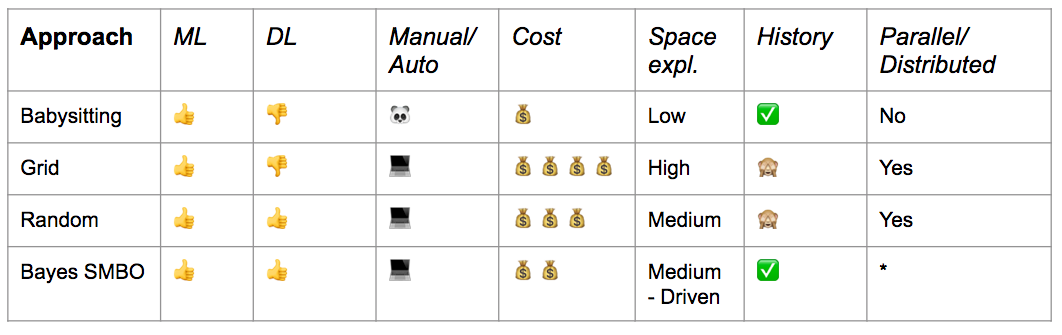

超参数搜索算法一般包含的要素
- 目标函数
- 搜索范围
- 其他参数，如步长等

### 模型搜索

In [94]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris

In [96]:
# 加载数据
iris = load_iris()
y = iris['target']
X = iris['data']
# 分为训练集和测试集
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
# 使用k折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [10]:
#使用xgboost在训练集上做交叉验证
xgb_model_list = []
xgb_mse_list = []
for train_index, test_index in kf.split(train_X):
    xgb_model = xgb.XGBClassifier().fit(train_X[train_index], train_y[train_index])
    xgb_model_list.append(xgb_model)
    predictions = xgb_model.predict(train_X[test_index])
    actuals = train_y[test_index]
    #print(confusion_matrix(actuals, predictions))
    mse = mean_squared_error(actuals, predictions)
    xgb_mse_list.append(mse)

print ('xgb_mse_list:{}'.format(xgb_mse_list))
print ('xgb mse均值为:{}'.format(np.mean(xgb_mse_list)))

xgb_mse_list:[0.0, 0.08333333333333333, 0.041666666666666664, 0.0, 0.08333333333333333]
xgb mse均值为:0.041666666666666664


In [6]:
#使用随机森林在训练集上做交叉验证
rf_model_list = []
rf_mse_list = []
for train_index, test_index in kf.split(train_X):
    rf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=10)
    rf_model_list.append(rf)
    rf.fit(train_X[train_index], train_y[train_index])
    predictions = rf.predict(train_X[test_index])
    actuals = train_y[test_index]
    mse = mean_squared_error(actuals, predictions)
    rf_mse_list.append(mse)

print ('rf_mse_list:{}'.format(rf_mse_list))
print ('rf mse均值为:{}'.format(np.mean(rf_mse_list)))

rf_mse_list:[0.08333333333333333, 0.041666666666666664, 0.08333333333333333, 0.041666666666666664, 0.08333333333333333]
rf mse均值为:0.06666666666666667


In [7]:
#模型评估和选择
if np.mean(rf_mse_list) <= np.mean(xgb_mse_list):
    min_mse = min(rf_mse_list)
    ind = rf_mse_list.index(mse)
    best_estimator = rf_model_list[ind]
    print('best estimator is random forest {}, mse is {}'.format(ind,min_mse))
else:
    min_mse = min(xgb_mse_list)
    ind = xgb_mse_list.index(min(xgb_mse_list))
    best_estimator = xgb_model_list[ind]
    print('best estimator is xgb {}, mse is {}'.format(ind, min_mse))

best estimator is xgb 0, mse is 0.0


In [8]:
#使用最好的模型和参数预测测试集，估计模型在实际使用时的判别能力
pred = best_estimator.predict(test_X)
mse = mean_squared_error(pred, test_y)
print ('test data mse is:{}'.format(mse))
print(confusion_matrix(test_y, pred))

test data mse is:0.03333333333333333
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]


### 参数搜索

In [101]:
# 网格搜索
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#把要调整的参数以及其候选值 列出来；
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100],
             "C":[0.001,0.01,0.1,1,10,100]}
print("Parameters:{}".format(param_grid))

grid_search = GridSearchCV(SVC(),param_grid,cv=5) #实例化一个GridSearchCV类
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state=10)
grid_search.fit(X_train,y_train) #训练，找到最优的参数，同时使用最优的参数实例化一个新的SVC estimator。
print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Parameters:{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
Test set score:0.97
Best parameters:{'C': 10, 'gamma': 0.1}
Best score on train set:0.98


In [102]:
# 网格搜索
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

#把要调整的参数以及其候选值 列出来；
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100],
             "C":[0.001,0.01,0.1,1,10,100]}
print("Parameters:{}".format(param_grid))

grid_search = RandomizedSearchCV(SVC(),param_grid,cv=5) #实例化一个GridSearchCV类
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state=10)
grid_search.fit(X_train,y_train) #训练，找到最优的参数，同时使用最优的参数实例化一个新的SVC estimator。
print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Parameters:{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
Test set score:0.97
Best parameters:{'gamma': 0.01, 'C': 100}
Best score on train set:0.97


### 神经网络的超参数搜索

In [1]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [2]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

搜索三个超参数
- 第一层神经元的个数
- Dropout的值
- 优化函数

In [4]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [5]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [6]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [7]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [8]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 60000 samples
10000/10000 [==============================] - 0s 31us/sample - loss: 0.5014 - accuracy: 0.8228
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
Train on 60000 samples
10000/10000 [==============================] - 0s 36us/sample - loss: 0.6426 - accuracy: 0.7851
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
Train on 60000 samples
10000/10000 [==============================] - 0s 32us/sample - loss: 0.5288 - accuracy: 0.8149
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
Train on 60000 samples
10000/10000 [==============================] - 0s 32us/sample - loss: 0.7120 - accuracy: 0.7671
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 60000 samples
10000/10000 [==============================] - 0s 32us/sample - loss: 0.4575 - accuracy: 0.8365
--

In [1]:
%tensorboard --logdir logs/hparam_tuning/ --bind_all

## 过拟合和欠拟合
过拟合是指模型对于训练数据拟合程度过当，在训练数据上的指标性能很好，但是到了新数据和测试集上性能很差。

欠拟合是指模型在训练和预测时表现都不好的情况。

- 降低"过拟合"风险的方法
    - 通过增加训练数据可有有效的降低噪音的影响，数据的获取是比较难的，可以通过数据增强获取大量数据。
    - 降低模型复杂度，在数据量较少时，过于复杂的模型更容易过拟合。
    - 正则化方法，给模型的参数加上一定的正则约束，L1和L2等。
    - 集成学习的方法，集成学习是把多个模型集成在一起，来降低单一模型的过拟合风险。
    - early stop技术

- 降低"欠拟合"风险的方法
    - 添加新特征，当特征不足或者现有的特征与样本标签相关性不强时，模型容易出现欠拟合。
    - 增加模型复杂度
    - 减小正则化系数

## AB Test/在线评估指标
进行在线评估主要有以下几个原因。
- 离线评估无法完全消除模型过拟合的影响，因此，得出的离线评估结果无法完全替代线上评估结果。
- 离线评估无法完全还原线上的工程环境，比如线上环境的延时、数据丢失、标签缺失等，在线下这些都是在比较理想的条件下进行的。
- 线上系统的某些商业指标在离线环境中无法计算。离线评估主要针对模型本身进行评估，而与模型相关的其他指标，特别是商业指标往往无法直接获得。比如推荐算法，离线评估会关注ROC曲线和PR曲线的改进，而线上的评估可以全面了解该推荐算法带来的用户点击率、留PV访问量等变化。这些都需要AB Test进行全面的评估。

### 如何进行AB Test
使用用户分桶，将用户分成实验组和对照组，对实验组的用户使用新模型，对照组使用旧模型，在分桶的过程中要注意用户样本的独立性和采样的无偏性，确保同一个用户每次只能分到同一个桶中。

[参考文档](https://cxl.com/blog/ab-testing-guide/)